# Colour Boosting

Uh so what we basically have here is like a qualifier and color booster rolled into one

So basically all pixels with a value within a given range of a given target colour (as determined by sigmoid fn on euclidean L*a*b distance) are shifted to target in accordance with that fn. More of a color grading thing if we wish to frame it that way. 

In [1]:
#!pip install tensorflow
#!pip install ipywidgets
#!pip install jupyterlab_widgets

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../jupyter/pal'))
if module_path not in sys.path:
    sys.path.append(module_path)

import cv2
import io
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import animation, rc
from mpl_toolkits.axes_grid1 import ImageGrid, Grid
import glob
import seaborn as sns
import ipywidgets as widgets

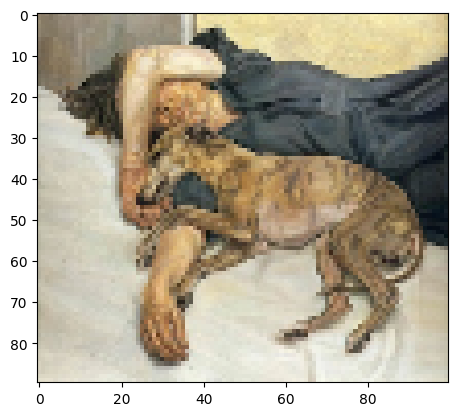

In [3]:
from lib.bild import Bild
from lib.helper import Helper

PATH = './pal/img/lucian_freud__double_portrait_small.jpg'

src_im = Bild.from_file(PATH)
src_im.resize(w=100, keep_ratio=True, inplace=True)
#src_im.scale(0.5)
#src_im.resize(h=160, keep_ratio=True)
lab_im = src_im.lab()
plt.imshow(src_im.rgb(normalize=True));

In [4]:
def dv(im, c):
    X = im.astype(float)
    C = np.ones(im.shape, np.float32) * c
    V = C - X
    D = np.square(V).sum(axis=2)**.5
    
    return D, V

def palette_vectors(im, palette):
    X = im.astype(float)
    
    vectors = []
    dists = []

    for c in palette:
        D, V = dv(im, c)

        dists.append(D)
        vectors.append(V)

    return np.array(dists), np.array(vectors)
    
def block_image(color, w, h):
    return cv2.cvtColor(
        np.uint8(np.full((w,h,3), color)),
        cv2.COLOR_LAB2RGB
    )
    
def color_squash(im, lab_color,
    Dd=300,  # Distance denominator (default ~= max L*a*b dist)
    sigL=1,  # Sigmoid max value
    sigk=1,  # Sigmoid steepness
    sigx0=0, # Sigmoid midpoint
):
    D, V = dv(im, lab_color)
    D = 1 - D/Dd
    D = sigL / (1 + np.exp(-((D-sigx0)*sigk)))
    
    # Scale vector by (modified) distance to colour
    V *= D.reshape((D.shape[0], D.shape[1], 1))
    return im + V, D, V



In [195]:
class Booster:
    @staticmethod
    def boost(lab_im, lab_color,
        Dd=300,  # Distance denominator (default ~= max L*a*b dist)
        sigL=1,  # Sigmoid max value
        sigk=10,  # Sigmoid steepness
        sigx0=0.8, # Sigmoid midpoint
    ):
        D, V = Booster._distance_vectors(lab_im, lab_color)
        D = 1 - D/Dd
        D = sigL / (1 + np.exp(-((D-sigx0)*sigk)))
    
        # Scale vector by (modified) distance to colour
        V *= D.reshape((D.shape[0], D.shape[1], 1))
        return lab_im + V, D, V
    
    @staticmethod
    def boost_multi(lab_im, configs, ordered=False):
        boosted_im = np.copy(lab_im)
        if len(configs) == 0: return boosted_im
        for config in configs:
            if ordered:
                boosted_im, _D, _V = Booster.boost(
                    boosted_im,
                    config['color'],
                    sigL=config['sigL'],
                    sigk=config['sigk'],
                    sigx0=config['sigx0']
                )
            else:
                _mod_im, D, V = Booster.boost(
                    lab_im,
                    config['color'],
                    sigL=config['sigL'],
                    sigk=config['sigk'],
                    sigx0=config['sigx0']
                )
                boosted_im = boosted_im + V
        return boosted_im

    @staticmethod
    def _distance_vectors(im, c):
        X = im.astype(float)
        C = np.ones(im.shape, np.float32) * c
        V = C - X
        D = np.square(V).sum(axis=2)**.5

        return D, V

In [5]:
ps = """
#0e4474 #0c3d67 #0b355a #092e4d
#082641 #061e34 #051727 #030f1a
#01080d #000000 #275e8e #3f709a
#5782a7 #6f94b3 #87a6c0 #9fb7cd
#b7c9d9 #cfdbe6 #e7edf2 #ffffff
""" + """
#98846d #533b2f #c5986d #debe96 #cac2b0 #331f16
"""

In [6]:
color_tags = widgets.ColorsInput(
    value=['#082641', '#c5986d', '#331f16', '#ffffff', '#e7edf2', '#cfdbe6', '#6f94b3', '#87a6c0'],
    allowed_tags=[],
    # allow_duplicates=False
    allow_duplicates=False
)
color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='blue',
    disabled=False,
)
out = widgets.Output()

#widgets.link((color_picker, 'value'), (color_tags, 'value'))

def on_value_change(change):
    print(color_tags.value)

    with out:
        with color_tags.hold_trait_notifications():
            if change["new"] not in color_tags.value:
                color_tags.value.append(change["new"])
                display(color_tags)
        
color_picker.observe(on_value_change, names='value')

box = widgets.VBox([color_picker, color_tags])
display(box)

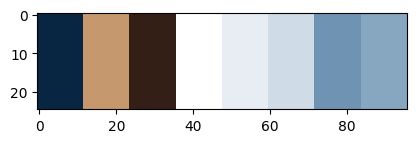

In [7]:
def print_palette(palette, w=100, h=100):
    palette_im = np.hstack([np.ones([h, w // len(palette), 3], np.uint8) * c for c in palette])
    
    fig = plt.figure(figsize=(w/10, h/20))
    plt.imshow(palette_im / 255)
 
rgb_palette = np.array([Helper.hex2rgb(h) for h in color_tags.value], np.uint8)
bgr_palette = cv2.cvtColor(np.array([rgb_palette]), cv2.COLOR_RGB2BGR)[0]
lab_palette = cv2.cvtColor(np.array([bgr_palette]), cv2.COLOR_BGR2LAB)[0]

print_palette(rgb_palette, w=100, h=25)

In [8]:
#import seaborn_image as 

color_tags = widgets.ColorsInput(
    value=['#082641', '#c5986d', '#331f16', '#ffffff', '#e7edf2', '#cfdbe6', '#6f94b3', '#87a6c0'],
    allowed_tags=[],
    # allow_duplicates=False
    allow_duplicates=False
)
color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='#6f94b3',
    disabled=False,
)

sigx0_slider = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    step=0.02,
    description='x0 (sigmoid midpoint):',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
sigk_slider = widgets.IntSlider(
    value=10,
    min=0,
    max=100,
    step=1,
    description='k: (sigmoid steepness)',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
)
sigL_slider = widgets.FloatSlider(
    value=1,
    min=0,
    max=1.5,
    step=0.02,
    description='L (sigmoid maximum):',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

def plot_squashed(color, sigx0, sigk, sigL=1):
    rgb_color = np.array([[Helper.hex2rgb(color)]], np.uint8)
    lab_color = cv2.cvtColor(rgb_color, cv2.COLOR_RGB2LAB)[0]
    
    mod_lab, D, _V = color_squash(lab_im, lab_color,
        sigL=sigL, sigk=sigk, sigx0=sigx0
    )
    mod_lab = np.uint8(mod_lab.astype(int))
    mod_rgb = cv2.cvtColor(mod_lab, cv2.COLOR_LAB2RGB)

    sig = [sigL / (1 + np.exp(-((x-sigx0)*sigk))) for x in np.arange(0,1,0.01)]
    plt.ioff()
    #fig2, ax2 = plt.subplots()
    #sns.lineplot(sig, ax=ax2)
    #plt.plot(sig)

    #with io.BytesIO() as buff:
    #    fig2.savefig(buff, format='raw')
    #    buff.seek(0)
    #    data = np.frombuffer(buff.getvalue(), dtype=np.uint8)
    #w, h = fig2.canvas.get_width_height()
    #sig_im = data.reshape((int(h), int(w), -1))
    #sig_im = cv2.resize(sig_im, (rgb_im.shape[0], rgb_im.shape[1]))
    
    # HACK to prevent plotter from normalizing
    D[0,0] = 1
    D[-1,-1] = 0
    #print(src_im.rgb.dtype)
    images = [
        block_image(lab_color, lab_im.shape[0], lab_im.shape[1]),
       # sig_im, # HACK trying to get the sigmoid plot in the grid too
        D,
        src_im.rgb(),
        mod_rgb,
    ]
                                     
    fig = plt.figure(figsize=(7., 7.))
    grid = ImageGrid(
         fig, 111,  # similar to subplot(111)
         nrows_ncols=(2, 2),  # creates grid of axes
         axes_pad=0,
    )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.axis("off")
        plt.xlabel("foo")
        ax.set_xticks([])
        ax.imshow(im)        

    plt.axis("off")
    plt.ion()
    plt.show()

#    fin = time.time()
#    duration = fin - start
#    print(f"took {duration} seconds.")

box = widgets.Box([
    widgets.VBox([color_picker]),
    widgets.VBox([
        sigx0_slider,
        sigL_slider,
        sigk_slider
    ])
])

reset_btn = widgets.Button(description="Reset")

def on_button_clicked(b):
    sigx0_slider.value = 0.5
    sigk_slider.value = 2
    sigL_slider.value = 1

reset_btn.on_click(on_button_clicked)

#plot_squashed("0000fc", 1, 0.5, 100)
#display(box)
widgets.interact(
    plot_squashed,
    color=color_picker,
    sigx0=sigx0_slider,
    sigk=sigk_slider,
    sigL=sigL_slider,
)
display(reset_btn)

interactive(children=(ColorPicker(value='#6f94b3', description='Pick a color'), FloatSlider(value=0.5, descrip…

Button(description='Reset', style=ButtonStyle())

In [9]:
#import seaborn_image as 

color_picker = widgets.ColorPicker(
    concise=False,
    description='Pick a color',
    value='#0957aa',
    disabled=False,
)
color_tags = widgets.ColorsInput(
    value=['#1e569f', '#c5986d', '#331f16'],
    allowed_tags=[],
    allow_duplicates=False
)

sigx0_slider = widgets.FloatSlider(
    value=0.8,
    min=0,
    max=1,
    step=0.05,
    description='x0 (sigmoid midpoint):',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
sigk_slider = widgets.IntSlider(
    value=15,
    min=0,
    max=100,
    step=1,
    description='k: (sigmoid steepness)',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
)
sigL_slider = widgets.FloatSlider(
    value=1,
    min=0,
    max=1,
    step=0.05,
    description='L (sigmoid maximum):',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)
ordered_toggle = widgets.Checkbox(
    value=False,
    description='Order transformations (recalcuate at each step)',
    disabled=False,
    indent=False
)

def squash_to_palette(im, color_configs, ordered=False):
    squashed_im = np.copy(im)
    if len(color_configs) == 0: return squashed_im
    for cnf in color_configs:
        if ordered:
            squashed_im, _D, _V = color_squash(
                squashed_im,
                cnf['color'],
#                Dd=cnf['Dd'],
                sigL=cnf['sigL'],
                sigk=cnf['sigk'],
                sigx0=cnf['sigx0']
            )
        else:
            _mod_im, D, V = color_squash(
                im,
                cnf['color'],
#                Dd=cnf['Dd'],
                sigL=cnf['sigL'],
                sigk=cnf['sigk'],
                sigx0=cnf['sigx0']
            )
            squashed_im = squashed_im + (V * D.reshape((D.shape[0], D.shape[1], 1)))
    return squashed_im

def plot_squashed_multi(colors, sigx0, sigk, sigL=1, ordered=False):
    rgb_colors = np.array([[Helper.hex2rgb(c)] for c in colors], np.uint8)
    lab_colors = cv2.cvtColor(rgb_colors, cv2.COLOR_RGB2LAB)
    
    configs = []
    for c in lab_colors:
        configs.append({
            'color': c,
            'sigx0': sigx0,
            'sigk': sigk,
            'sigL': sigL,
        })
    
    mod_lab = squash_to_palette(lab_im, configs, ordered=ordered)
    mod_lab = np.uint8(mod_lab.astype(int))
    mod_rgb = cv2.cvtColor(mod_lab, cv2.COLOR_LAB2RGB)
    
    images = [
        src_im.rgb(),
        mod_rgb,
    ]
                                     
    fig = plt.figure(figsize=(15., 15.))
    grid = ImageGrid(
         fig, 111,  # similar to subplot(111)
         nrows_ncols=(1, 2),  # creates grid of axes
         axes_pad=0,
    )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.axis("off")
        plt.xlabel("foo")
        ax.set_xticks([])
        ax.imshow(im)        

    plt.axis("off")
    plt.show()

box = widgets.Box([
    widgets.VBox([color_picker]),
    widgets.VBox([
        sigx0_slider,
        sigL_slider,
        sigk_slider
    ])
])

#plot_squashed("0000fc", 1, 0.5, 100)
display(color_picker)
widgets.interact(
    plot_squashed_multi,
    colors=color_tags,
    sigx0=sigx0_slider,
    sigk=sigk_slider,
    sigL=sigL_slider,
    ordered=ordered_toggle
)


ColorPicker(value='#0957aa', description='Pick a color')

interactive(children=(ColorsInput(value=['#1e569f', '#c5986d', '#331f16'], allow_duplicates=False, description…

<function __main__.plot_squashed_multi(colors, sigx0, sigk, sigL=1, ordered=False)>

In [219]:
import base64
import cv2
import json

from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, Javascript

from lib.bild import Bild
from lib.helper import Helper

class AppDisplay:
    def __init__(self, app):
        self.app = app
        app.display = self
        self.input_image = None
        self.image = widgets.HTML(value="<h3>Upload an Image!</h3>")
    
    def display(self):
        display(self.app.widgets['output'])

        self.controls = widgets.VBox([
            widgets.HTML("<h2>Colour Booster</h2>"),
            widgets.HBox([
                self.app.widgets['upload_image'],
                self.app.widgets['add_layer'],
                self.app.widgets['upload_layers'],
                self.app.widgets['save_layers'],
                self.app.widgets['save_image'],
            ]),
            self.app.widgets['ordered'],
        ])

        self.layout = widgets.AppLayout(
            header=self.controls,
            left_sidebar=self.layers(),
            center=None,
            right_sidebar=self.image,
            footer=None
        )
        display(self.layout)
        
    def layers(self):
        layers = []
        titles = []
        for layer in self.app.layers:
            box = widgets.VBox([
                layer.widgets['toggle'],
                layer.widgets['color'],
                layer.widgets['sigx0'],
                layer.widgets['sigk'],
                layer.widgets['sigL'],
                widgets.HBox([
                    layer.widgets['reset'],
                    layer.widgets['destroy']
                ])
            ])
            layers.append(box)
            titles.append(layer.widgets['color'].value)
        return widgets.Accordion(children=layers, titles=titles)
    
    def refresh(self):
        self.layout.left_sidebar = self.layers()
        self.refresh_image()
        
    def refresh_image(self):
        if self.app.image:
            if not self.input_image:
                self.image = widgets.Image(format='png')
                self.layout.right_sidebar = self.image
            self.input_image = self.app.preview
            output_image = self.app.output_image
            self.image.value = self.input_image.concat(output_image).to_bytes('png')
        else:
            self.image = widgets.HTML(value="<h3>Upload an Image!</h3>")


class App:
    class NullDisplay:
        def __init__(self): pass
        def refresh(self): pass
        def refresh_image(self): pass

    def __init__(self):
        self.state = 'idle'
        self.layers = []
        self.ordered = False
        self.image = None
        self.output_image = None
        self.display = App.NullDisplay()
        self.preview = None
        self.widgets = {
            'add_layer': widgets.Button(
                description="Add A Layer",
                button_style="primary",
                icon="fa-plus",
                disabled=True,
            ),
            'save_layers': widgets.Button(
                description="Save Layers",
                button_style="info",
                icon="fa-save",
                disabled=True,
            ),
            'upload_layers': widgets.FileUpload(
                accept='application/json',
                description="Load Layers",
                button_style="info",
                tooltip="Open layer file",
                disabled=True,
                multiple=False,
            ),
            'upload_image': widgets.FileUpload(
                accept='image/*',
                description="Upload Image",
                button_style="primary",
                tooltip="Upload an image to edit",
                disabled=False,
                multiple=False,
            ),
            'save_image': widgets.Button(
                description="Save Result",
                button_style="success",
                disabled=True,
                icon="fa-check",
            ),
            'ordered': widgets.Checkbox(
                value=False,
                description='Order layers (recalcuate at each step)',
                disabled=True,
                indent=False
            ),
            'output': widgets.Output()
        }
        self.widgets['add_layer'].on_click(self.add_layer)
        self.widgets['save_layers'].on_click(self.save_layers)
        self.widgets['save_image'].on_click(self.save_image)
        self.widgets['upload_image'].observe(self.upload_image)
        self.widgets['upload_layers'].observe(self.load_layers)
        self.widgets['ordered'].observe(self.refresh_image)
    
    def refresh(self, _=None):
        pass

    def refresh_image(self, _=None):
        if not self.image: return

        configs = [l.booster_config() for l in self.layers if l.enabled]
        lab_im = self.preview.lab()
        boosted_lab = Booster.boost_multi(
            lab_im,
            configs,
            ordered=self.widgets['ordered'].value
        )
        boosted_lab = np.uint8(boosted_lab.astype(int))
        boosted_im = Bild(cv2.cvtColor(boosted_lab, cv2.COLOR_LAB2RGB))
        self.output_image = boosted_im
        self.display.refresh_image()

    def add_layer(self, _btn, config={}):
        layer = Layer(self, config)
        self.layers.append(layer)
        self.display.refresh()

    def delete_layer(self, layer):
        self.layers = [l for l in self.layers if l != layer]
        self.display.refresh()

    def upload_image(self, change):
        if len(change.owner.value):
            bytestr = change.owner.value[0].content.tobytes()
            im = Bild.from_bytes(bytestr)
            preview_im = im.resize(w=300, keep_ratio=True)
            self.image = im
            self.preview = preview_im
            self.output_image = preview_im

            self.enable_buttons()
            self.display.refresh_image()

    def save_image(self, _btn):
        self.disable_buttons()
        configs = [l.booster_config() for l in self.layers if l.enabled]
        lab_im = self.image.lab()
        boosted_lab = Booster.boost_multi(
            lab_im,
            configs,
            ordered=self.widgets['ordered'].value
        )
        boosted_lab = np.uint8(boosted_lab.astype(int))
        boosted_im = Bild(cv2.cvtColor(boosted_lab, cv2.COLOR_LAB2RGB))
        im_bytes = boosted_im.to_bytes('png')
        b64_bytes = base64.b64encode(im_bytes)
        b64_str = b64_bytes.decode('ascii')
        js_code = """
            var a = document.createElement("a");
            a.href = "data:%s;base64,%s";
            a.download = 'result.png';
            a.click();
            a.remove();
        """
        with self.widgets['output']:
            js = Javascript(js_code % ("image/png", b64_str))
            display(js)
            self.widgets['output'].clear_output()
            self.enable_buttons()

    def save_layers(self, _btn):
        layer_configs = []
        for layer in self.layers:
            config = layer.booster_config()
            del config["color"]
            layer_configs.append(config)

        data = {
            'layers': layer_configs,
            'ordered': self.ordered,
        }
        message_bytes = json.dumps(data).encode('ascii')
        b64_str = base64.b64encode(message_bytes).decode('ascii')

        js_code = """
            var a = document.createElement("a");
            a.href = "data:%s;base64,%s"
            a.download = "booster_layers.json";
            a.click();
            a.remove()
        """
        with self.widgets['output']:
            js = Javascript(js_code % ("application/json", b64_str))
            display(js)
            self.widgets['output'].clear_output()
            
    def load_layers(self, change):
        if len(change.owner.value):
            bytestr = change.owner.value[0].content.tobytes()
            layers_json = bytestr.decode('utf8')
            config = json.loads(layers_json)
            self.layers = [Layer(self, c) for c in config['layers']]
            self.ordered = config.get('ordered', False)
            self.display.refresh()
    
    def disable_buttons(self):
        for w in self.widgets.values(): w.disabled = True
            
    def enable_buttons(self):
        for w in self.widgets.values(): w.disabled = False

class Layer:
    def __init__(self, parent, config={}):
        self.parent = parent
        self.enabled = config.get('enabled', True)
        self.widgets = {
            'color': widgets.ColorPicker(
                concise=False,
                description='Pick a color',
                value=config.get('hexColor', '#ff2211'),
                disabled=False,
            ), 
            'sigx0': widgets.FloatSlider(
                value=config.get('sigx0', 0.8),
                min=0,
                max=1,
                step=0.05,
                description='x0 (sigmoid midpoint):',
                disabled=False,
                continuous_update=True,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
            ),
            'sigk': widgets.IntSlider(
                value=config.get('sigk', 15),
                min=0,
                max=100,
                step=1,
                description='k: (sigmoid steepness)',
                disabled=False,
                continuous_update=True,
                orientation='horizontal',
                readout=True,
            ),
            'sigL': widgets.FloatSlider(
                value=config.get('sigL', 1),
                min=0,
                max=1,
                step=0.05,
                description='L (sigmoid maximum):',
                disabled=False,
                continuous_update=True,
                orientation='horizontal',
                readout=True,
                readout_format='.1f',
            ),
            'reset': widgets.Button(description="Reset", icon="fa-refresh"),
            'destroy': widgets.Button(
                description="Remove",
                button_style='danger',
                icon="fa-trash-o",
            ),
            'toggle': widgets.Button(
                description='Enabled',
                button_style='success',
                tooltip='Click to toggle',
                icon='toggle-on'
            )
        }
        self.widgets['reset'].on_click(self.reset)
        self.widgets['destroy'].on_click(self.destroy)
        self.widgets['toggle'].on_click(self.toggle)
        
        for w in ["sigx0", "sigk", "sigL", "color", "toggle"]:
            self.widgets[w].observe(self.parent.refresh_image)
            
    def toggle(self, btn):
        self.enabled = not self.enabled
        if self.enabled:
            btn.description = 'Enabled'
            btn.button_style = 'success'
            btn.icon = 'toggle-on'
        else:
            btn.description = 'Disabled'
            btn.button_style = 'warning'
            btn.icon = 'toggle-off'

        for w in ["sigx0", "sigk", "sigL", "color", "reset"]:
            self.widgets[w].disabled = not self.enabled
            
    
    def reset(self, _b):
        self.widgets['sigx0'].value = 0.8
        self.widgets['sigk'].value = 15
        self.widgets['sigL'].value = 1
        
    def destroy(self, _b):
        self.parent.delete_layer(self)

    def booster_config(self):
        rgb_color = np.array([[Helper.hex2rgb(self.widgets['color'].value)]], np.uint8)
        lab_color = cv2.cvtColor(rgb_color, cv2.COLOR_RGB2LAB)
    
        config = {
            'hexColor': self.widgets['color'].value,
            'color': lab_color,
            'sigx0': self.widgets['sigx0'].value,
            'sigk': self.widgets['sigk'].value,
            'sigL': self.widgets['sigL'].value,
            'enabled': self.enabled,
        }
        return config
    
app = AppDisplay(App())
app.display()

Output()

AppLayout(children=(VBox(children=(HTML(value='<h2>Colour Booster</h2>'), HBox(children=(FileUpload(value=(), …

In [35]:
j = Javascript("window.open('%s')" % "./layers.json")
display(j)
print("foo")

<IPython.core.display.Javascript object>

foo


In [220]:
# TODO:
#   Allow layers to be moved up and down
#   Duplicate a Layer
#   Save as LUT
#   Different colorspaces and distance functions (use the colors library)
#      https://colour.readthedocs.io/en/develop/index.html
#   Clamp to valid RGB range
#   Palette from image
#   Working state - disable everything, display spinner


import json
import base64

from __future__ import print_function
import ipywidgets as widgets
from IPython.display import display, Javascript

out = widgets.Output()
display(out)

def config_from_layer(layer):
    rgb_color = np.array([[Helper.hex2rgb(layer.children[0].value)]], np.uint8)
    lab_color = cv2.cvtColor(rgb_color, cv2.COLOR_RGB2LAB)
    
    config = {
        'hexColor': layer.children[0].value,
        'color': lab_color,
        'sigx0': layer.children[1].value,
        'sigk': layer.children[2].value,
        'sigL': layer.children[3].value,
    }
    return config

def add_layer_widgets(parent, im_widget, config={}, reproc=True):
    color_picker = widgets.ColorPicker(
        concise=False,
        description='Pick a color',
        value=config.get('hexColor', '#0957aa'),
        disabled=False,
    )
    sigx0_slider = widgets.FloatSlider(
        value=config.get('sigx0', 0.8),
        min=0,
        max=1,
        step=0.05,
        description='x0 (sigmoid midpoint):',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )
    sigk_slider = widgets.IntSlider(
        value=config.get('sigk', 15),
        min=0,
        max=100,
        step=1,
        description='k: (sigmoid steepness)',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
    )
    sigL_slider = widgets.FloatSlider(
        value=config.get('sigL', 1),
        min=0,
        max=1,
        step=0.05,
        description='L (sigmoid maximum):',
        disabled=False,
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )
    
    reset_btn = widgets.Button(description="Reset", icon="fa-refresh")
    def on_reset_button_clicked(b):
        sigx0_slider.value = 0.8
        sigk_slider.value = 15
        sigL_slider.value = 1

    reset_btn.on_click(on_reset_button_clicked)
    
    destroy_btn = widgets.Button(
        description="Remove",
        button_style='danger',
        icon="fa-trash-o",
    )
    
    
    def reprocess(_):
        im = STATE['preview']
        configs = [config_from_layer(l) for l in parent.children]
        mod_lab = Booster.boost_multi(im.lab(), configs)
        mod_lab = np.uint8(mod_lab.astype(int))
        mod_rgb = cv2.cvtColor(mod_lab, cv2.COLOR_LAB2RGB)
        im_widget.value = im.concat(Bild(mod_rgb)).resize(w=200, keep_ratio=True).to_bytes('png')
        
    def finalize():
        im = STATE['im']
        configs = [config_from_layer(l) for l in parent.children]
        mod_lab = Booster.boost_multi(im.lab(), configs)
        mod_lab = np.uint8(mod_lab.astype(int))
        mod_im = Bild(cv2.cvtColor(mod_lab, cv2.COLOR_LAB2RGB))
        return mod_im
    
    color_picker.observe(reprocess)
    sigx0_slider.observe(reprocess)
    sigL_slider.observe(reprocess)
    sigk_slider.observe(reprocess)
    
    box = widgets.VBox([
        color_picker,
        sigx0_slider,
        sigk_slider,
        sigL_slider,
        widgets.HBox([reset_btn, destroy_btn])
    ])
    
    def on_remove_btn_clicked(b):
        parent.children = [w for w in parent.children if w != box]
        reprocess(parent)
        
    destroy_btn.on_click(on_remove_btn_clicked)

    parent.children += (box,)
    if reproc: reprocess(None)
    return {
        'reprocess': reprocess,
        'finalize': finalize,
    }
    
ordered_toggle = widgets.Checkbox(
    value=False,
    description='Order transformations (recalcuate at each step)',
    disabled=False,
    indent=False
)

layers = widgets.VBox([])
STATE = {
    'im': src_im,
    'preview': src_im.resize(w=100, keep_ratio=True),
    'ordered': False,
}

add_color_btn = widgets.Button(
    description="Add A Layer",
    button_style="primary",
    icon="fa-plus",
)

layer_save_btn = widgets.Button(
    description="Save Layers",
    button_style="info",
    icon="fa-save",
)

layer_upload_btn = widgets.FileUpload(
    accept='application/json',
    description="Load Layers",
    button_style="info",
    tooltip="Open layer file",
    multiple=False,
)

im_upload_btn = widgets.FileUpload(
    accept='image/*',
    description="Upload Image",
    button_style="primary",
    tooltip="Upload an image to edit",
    multiple=False,
)

im_save_btn = widgets.Button(
    description="Save Result",
    button_style="success",
    icon="fa-check",
)

im_widget = widgets.Image(
    format='png',
    value=src_im.concat(src_im).to_bytes('png')
)

layer_obj = add_layer_widgets(layers, im_widget)

def add_color_button_clicked(b):
    add_layer_widgets(layers, im_widget)

add_color_btn.on_click(add_color_button_clicked)

def save_layers_button_clicked(b):
    layer_configs = []
    for layer in layers.children:
        config = config_from_layer(layer)
        del config["color"]
        layer_configs.append(config)
    
    data = {
        'layers': layer_configs,
        'ordered': STATE['ordered'],
    }
    json_data = json.dumps(data)
    message_bytes = json_data.encode('ascii')
    b64_bytes = base64.b64encode(message_bytes)
    b64_str = b64_bytes.decode('ascii')

    js_code = """
        var a = document.createElement("a");
        a.href = "data:%s;base64,%s"
        a.download = "booster_layers.json";
        a.click();
        a.remove()
    """
    with out:
        js = Javascript(js_code % ("application/json", b64_str))
        display(js)
        out.clear_output()
    

layer_save_btn.on_click(save_layers_button_clicked)

def image_uploaded(change):
    if len(change.owner.value):
        bytestr = change.owner.value[0].content.tobytes()
        im = Bild.from_bytes(bytestr)
        preview_im = im.resize(w=300, keep_ratio=True)
        STATE['im'] = im
        STATE['preview'] = preview_im
        layer_obj['reprocess'](None)

im_upload_btn.observe(image_uploaded)

def layer_file_uploaded(change):
    if len(change.owner.value):
        bytestr = change.owner.value[0].content.tobytes()
        layers_json = bytestr.decode('utf8')
        layers_config = json.loads(layers_json)
        layers.children = tuple([])
        for layer_config in layers_config['layers']:
            add_layer_widgets(layers, im_widget, config=layer_config, reproc=False)
            
        layer_obj['reprocess'](None)

layer_upload_btn.observe(layer_file_uploaded)

def save_im_btn_clicked(b):
    img_bytes = layer_obj['finalize']().to_bytes('png')
    b64_bytes = base64.b64encode(img_bytes)
    b64_str = b64_bytes.decode('ascii')
    js_code = """
        var a = document.createElement("a");
        a.href = "data:%s;base64,%s";
        a.download = 'result.png';
        a.click();
        a.remove();
    """
    with out:
        js = Javascript(js_code % ("image/png", b64_str))
        display(js)
        out.clear_output()


im_save_btn.on_click(save_im_btn_clicked)
        
controls = widgets.VBox([
    widgets.HBox([
        im_upload_btn,
        add_color_btn,
        layer_upload_btn,
        layer_save_btn,
        im_save_btn,
    ]),
    ordered_toggle,
])


layout = widgets.AppLayout(
    header=controls,
    left_sidebar=layers,
    center=None,
    right_sidebar=im_widget,
    footer=None
)
display(layout)

Output()

AppLayout(children=(VBox(children=(HBox(children=(FileUpload(value=(), accept='image/*', button_style='primary…

In [80]:
{}.get(33, 100)

100

In [ ]:
import time
start = time.time()

pal = [
    lab_palette[3],
    lab_palette[0],
    lab_palette[1],
]

dists, vectors = palette_vectors(lab_im, pal)
#dists, vectors = palette_vectors(rgb_im, rgb_palette)

images = []
#np.array(hex2rgb(h))
# calculate all distances and overlay transforms
ov_im_arr = np.copy(lab_im)
# recalculate distances after each step
acc_im_arr = np.copy(lab_im)

steep = 12
for i, c in enumerate(pal):
    Dexp = 64
    
    Di, Vi = dv(acc_im_arr, c)
    Di = 1 - Di/400
    Di = 1/(1 + np.exp(-((Di-0.5)*steep)))
    Di = Di ** Dexp
    di_im = Di
    
    Vi *= Di.reshape((Di.shape[0], Di.shape[1], 1))
    
    acc_im_arr = acc_im_arr + Vi
    acc_im = np.uint8(acc_im_arr.astype(int))
    acc_im  = cv2.cvtColor(acc_im, cv2.COLOR_LAB2RGB)

    
    D = dists[i]
    V = vectors[i]
    
    

    # TODO: normalise_properly
    #D = D / max(D)
    D = D/300 # my rough estimate of max lab distance
    D = 1-D
    D = 1/(1 + np.exp(-((D-0.5)*steep)))
    D = D ** Dexp

    # Scale vector by distance to colour
    V *= D.reshape((D.shape[0], D.shape[1], 1))

    d_im = D
    v_im = V
    
    mod_im = lab_im + v_im
    mod_im = np.uint8(mod_im.astype(int))
    mod_im = cv2.cvtColor(mod_im, cv2.COLOR_LAB2RGB)
    
    ov_im_arr = ov_im_arr + v_im
    ov_im = np.uint8(ov_im_arr.astype(int))
    ov_im = cv2.cvtColor(ov_im, cv2.COLOR_LAB2RGB)
    
    #d_im = d_im * 255
    
    #d_im = np.uint8(d_im.astype(int))
    
    
    
    images.append(block_image(c, lab_im.shape[0], lab_im.shape[1]))
    images.append(d_im)
    images.append(mod_im)
    images.append(np.copy(ov_im))
    images.append(di_im)
    images.append(acc_im)

cols = 6
rows = int(len(images)/cols)
fig = plt.figure(figsize=(10., 10.*rows))
grid = ImageGrid(
     fig, 111,  # similar to subplot(111)
     nrows_ncols=(rows, cols),  # creates grid of axes
     axes_pad=0,
)
for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    ax.axis("off")
    plt.xlabel("foo")
    ax.imshow(im)
    
    ax.set_xticks([])
plt.axis("off")
plt.show()

fin = time.time()

duration = fin - start

print(f"took {duration} seconds.")

In [ ]:
fig = plt.figure(figsize=(10., 20))
grid = ImageGrid(
     fig, 111,  # similar to subplot(111)
     nrows_ncols=(1, 3),  # creates grid of axes
     axes_pad=0,
)
for ax, im in zip(grid, [rgb_im, images[-3], images[-1]]):
    # Iterating over the grid returns the Axes.
    ax.axis("off")
    plt.xlabel("foo")
    ax.imshow(im)
    
    ax.set_xticks([])

plt.axis("off")
plt.show()

In [ ]:
min(images[0][1])

In [ ]:
sns.lineplot([(float(n) / 100) **3 for n in range(100)])

In [ ]:
sig = [1/(1 + np.exp(-((x-0.5)*20))) for x in np.arange(0,1,0.01)]

sigs = [[s**p for s in sig] for p in range(0,10)]

sns.lineplot(sigs)

In [ ]:
import timeit

setup = """import numpy as np
def solid_ctrl():
    h = 240
    w = 480
    p_im = np.ones([h, w, 3], np.uint8)
    c = [64, 128, 255]
    for j in range(w):
        for i in range(h):
            p_im[i,j] = c

def solid_test():
    h, w = 240, 480
    c = [64, 128, 255]
    np.ones([h, w, 3], np.uint8) * c
"""
number = 100
rep = 5
t1 = timeit.repeat("solid_ctrl()", setup=setup, number=number, repeat=rep)
t2 = timeit.repeat("solid_test()", setup=setup, number=number, repeat=rep)

print(t1, t2)